In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, transforms

import time
import numpy as np
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

In [2]:
dataset_dir = './Dataset/'
batch_size = 4
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
learning_rate = 0.01

In [3]:
class YouTubePose(Dataset):
    
    def __init__(self, datapoint_pairs, shapeLoss_datapoint_pairs, dataset_dir, transform=None, mode='train'):
        self.datapoint_pairs = datapoint_pairs
        self.shapeLoss_datapoint_pairs = shapeLoss_datapoint_pairs
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.datapoint_pairs)
    
    def __getitem__(self, idx):
        image_pair = self.datapoint_pairs[idx]
        x_gen_path = image_pair[0]
        x_dis_path = image_pair[1]
        y_path = image_pair[2]
        
        identity_pair = self.shapeLoss_datapoint_pairs[idx]
        iden_1_path = identity_pair[0]
        iden_2_path = identity_pair[1]
        
        x_gen = Image.open(self.dataset_dir + self.mode + '/' + x_gen_path)
        x_dis = Image.open(self.dataset_dir + self.mode + '/' + x_dis_path)
        y = Image.open(self.dataset_dir + self.mode + '/' + y_path)
        iden_1 = Image.open(self.dataset_dir + self.mode + '/' + iden_1_path)
        iden_2 = Image.open(self.dataset_dir + self.mode + '/' + iden_2_path)
        
        if self.transform:
            x_gen = self.transform(x_gen)
            x_dis = self.transform(x_dis)
            y = self.transform(y)
            iden_1 = self.transform(iden_1)
            iden_2 = self.transform(iden_2)
            
        sample = {'x_gen' : x_gen, 'x_dis': x_dis, 'y': y, 'iden_1': iden_1, 'iden_2':iden_2}
        return sample

In [4]:
with open('train_datapoint_triplets.pkl', 'rb') as f:
    datapoint_pairs = pickle.load(f)

In [5]:
with open('train_shapeLoss_pairs.pkl', 'rb') as f:
    shapeLoss_datapoint_pairs = pickle.load(f)

In [6]:
len(datapoint_pairs)

6000

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [8]:
train_dataset = YouTubePose(datapoint_pairs, shapeLoss_datapoint_pairs, dataset_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                                             num_workers=0)

In [9]:
dataset_sizes = [len(train_dataset)]

0 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
1 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
2 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
3 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


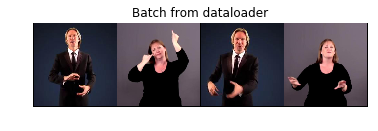

In [10]:
def show_landmarks_batch(sample_batched):
    
    images_batch, landmarks_batch = sample_batched['iden_1'], sample_batched['iden_2']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    grid1 = utils.make_grid(landmarks_batch)
    
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.imshow(grid1.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
    
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['x_gen'].size(), sample_batched['y'].size())
    
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [11]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x.to(device)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [12]:
class Generator(nn.Module):
    def __init__(self, block):
        super(Generator, self).__init__()
        
        self.conv1_x = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2))
        
        self.conv2_x = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2))

        self.conv3_x = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True))

        self.conv1_y = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2))
        
        self.conv2_y = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2))

        self.conv3_y = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True))      
        
#         self.conv1_x = nn.Conv2d(3, 16, 3, padding = 1)
#         self.conv2_x = nn.Conv2d(16, 32, 3)
#         self.conv3_x = nn.Conv2d(32, 16, 3, padding=1)

#         self.conv1_y = nn.Conv2d(3, 16, 3)
#         self.conv2_y = nn.Conv2d(16, 32, 3)
#         self.conv3_y = nn.Conv2d(32, 16, 3, padding = 1)

#         self.relu = nn.ReLU()
#         self.avgpool = nn.AvgPool2d(2)
        
    
        # 2 Residual Blocks for Identity Image
        self.block1_x = block(16, 16)
#         downsample_x = nn.Sequential(conv3x3(16, 1, 1), nn.BatchNorm2d(1))
#         self.block2_x = block(16, 1, 1, downsample_x)
        self.block2_x = block(16, 16)

        # 2 Residual Blocks for Shape Image
        self.block1_y = block(16, 16)
#         downsample_y = nn.Sequential(conv3x3(16, 1, 1), nn.BatchNorm2d(1))
#         self.block2_y = block(16, 1, 1, downsample_y)
        self.block2_y = block(16, 16)
        # 2 Residual Blocks for Combined(concat) image
        downsample1_concat = nn.Sequential(conv3x3(32, 16, 1), nn.BatchNorm2d(16))
        self.block1_concat = block(32, 16, 1, downsample1_concat)

        self.block2_concat = block(16, 16)
        
#         self.deconv1 = nn.ConvTranspose2d(16, 16, 3)
#         self.deconv2 = nn.ConvTranspose2d(16, 3, 3)
        
    
#          self.conv2_y = nn.Sequential(
#             nn.Conv2d(16, 32, 3, padding = 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.AvgPool2d(2))
    
        self.upsample1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        
        self.upsample2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 3, 3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True))
        
        
    def forward(self, x, y):
        
        x = self.conv1_x(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.block1_x(x)
        x = self.block2_x(x)
        
        y = self.conv1_y(y)
        y = self.conv2_y(y)
        y = self.conv3_y(y)
        y = self.block1_y(y)
        y = self.block2_y(y)
        
        concat_result = torch.zeros([x.shape[0], x.shape[1] * 2, x.shape[2], x.shape[3]], dtype=x.dtype)
#         print(x.shape, y.shape, concat_result.shape)
        for i in range(batch_size):
            for j in range(x.shape[1]):
                concat_result[i][j] = x[i][j]
                concat_result[i][j + x.shape[1]] = y[i][j]
        
        concat_result = concat_result.to(device)
        concat_result = self.block1_concat(concat_result)
        concat_result = self.block2_concat(concat_result)
        
        upsampled_1 = self.upsample1(concat_result)
        upsampled_2 = self.upsample2(upsampled_1)
#         print(upsample2.shape)
        return upsampled_2
        

In [13]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        
        use_bias = norm_layer

        kw = 3
        padw = 1
        sequence = []
#         sequence = [
#             nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
#             nn.LeakyReLU(0.2, True)
#         ]
        self.initial_conv = nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw)
        self.initial_relu = nn.LeakyReLU(0.2, True)
        
    
        ndf = 128
        
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)
        
        self.maxpool = nn.MaxPool2d(8)
    def forward(self, x, y):
        x = self.initial_relu(self.initial_conv(x))
        y = self.initial_relu(self.initial_conv(y))
        
        concat_fmap = torch.zeros([x.shape[0], 2 * x.shape[1], x.shape[2], x.shape[3]], dtype=x.dtype)
#         print(x.shape, y.shape, concat_result.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                concat_fmap[i][j] = x[i][j]
                concat_fmap[i][j + 64] = y[i][j]
        concat_fmap = concat_fmap.to(device)
        op = self.model(concat_fmap)
        op_neg = - op
        op_neg = self.maxpool(op_neg)
        op_pooled = -op_neg
        
        return op, op_pooled

In [14]:
generator = Generator(ResidualBlock)

In [15]:
discriminator = NLayerDiscriminator(3)

In [16]:
# sample = []
# for i_batch, sample_batched in enumerate(train_dataloader):
#     sample = sample_batched
#     if i_batch == 0:
#         break

In [17]:
# op = generator(sample['x_gen'], sample['y'])
# op.shape

In [18]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [19]:
# def lossIdentity(real_pooled_op, fake_pooled_op):
#     batch_size = real_pooled_op.size()[0]
#     real_pooled_op = 1 - real_pooled_op
#     real_pooled_op = real_pooled_op ** 2
#     fake_pooled_op  = (fake_pooled_op ** 2)
#     real_pooled_op = real_pooled_op.view(batch_size, -1)
#     fake_pooled_op = fake_pooled_op.view(batch_size, -1)
#     real_pooled_op = torch.sum(real_pooled_op, dim = 1)
#     fake_pooled_op = torch.sum(fake_pooled_op, dim = 1)
#     return (real_pooled_op + fake_pooled_op) / batch_size

def lossIdentity(real_pair, fake_pair):
    batch_size = real_pair.size()[0]
    real_pair = 1 - real_pair
    real_pair = real_pair ** 2
    fake_pair  = fake_pair ** 2
    real_pair = torch.sum(real_pair)
    fake_pair = torch.sum(fake_pair)
    return (real_pair + fake_pair) / batch_size

In [20]:
def lossShape(x, y):
    batch_size = x.size()[0]
    diff = x - y
    diff = diff ** 2
    diff = torch.sum(diff) / batch_size
    return diff

In [21]:
def train_model(gen, disc, loss_i, loss_s, optimizer_gen, optimizer_disc, alpha = 1, beta = 1, num_epochs = epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-'*10)
        dataloader = train_dataloader
        gen.train()
        disc.train()
        since = time.time()
        running_loss_iden = 0.0
        running_loss_s1 = 0.0
        running_loss_s2a = 0.0
        running_loss_s2b = 0.0
        running_loss = 0.0
        
        for i_batch, sample_batched in enumerate(dataloader):
            x_gen, y, x_dis = sample_batched['x_gen'], sample_batched['y'], sample_batched['x_dis']
            iden_1, iden_2 = sample_batched['iden_1'], sample_batched['iden_2']
            x_gen = x_gen.to(device)
            y = y.to(device)
            x_dis = x_dis.to(device)
            iden_1 = iden_1.to(device)
            iden_2 = iden_2.to(device)
            
            optimizer_gen.zero_grad()
            optimizer_disc.zero_grad()
            
            with torch.set_grad_enabled(True):
                x_generated = gen(x_gen, y)
                print('forward 1 done')
                fake_op, fake_pooled_op = disc(x_gen, x_generated)
                real_op, real_pooled_op = disc(x_gen, x_dis)
                loss_identity_gen = -loss_i(real_pooled_op, fake_pooled_op)
                print('Loss calculated')
                loss_identity_gen.backward(retain_graph=True)
                optimizer_gen.step()
                print('backward 1.1 done')
                
                optimizer_disc.zero_grad()
                loss_identity_disc = loss_i(real_op, fake_op)
                print('Loss calculated')
                loss_identity_disc.backward(retain_graph=True)
                optimizer_disc.step()
                print('backward 1.2 done')

                optimizer_gen.zero_grad()
                optimizer_disc.zero_grad()
                x_ls2a = gen(y, x_generated)
                x_ls2b = gen(x_generated, y)
                print('forward 2 done')

                loss_s2a = loss_s(y, x_ls2a)
                loss_s2b = loss_s(x_generated, x_ls2b)
                loss_s2 = loss_s2a + loss_s2b
                print('Loss calculated')

                loss_s2.backward()
                optimizer_gen.step()
                print('backward 2 done')

                optimizer_gen.zero_grad()
                optimizer_disc.zero_grad()
                
                x_ls1 = generator(iden_1, iden_2)
                print('forward 3 done')

                loss_s1 = loss_s(iden_2, x_ls1)
                print('Loss calculated')
                loss_s1.backward()
                optimizer_gen.step()
                print('backward 5 done')
                print()
            running_loss_iden += loss_identity_disc.item() * x_gen.size(0)
            running_loss_s1 += loss_s1.item() * x_gen.size(0)
            running_loss_s2a += loss_s2a.item() * x_gen.size(0) 
            running_loss_s2b += loss_s2b.item() * x_gen.size(0)
            running_loss = running_loss_iden +  beta * (running_loss_s1 + alpha * (running_loss_s2a + running_loss_s2b))
            print(str(time.time() - since))
            since = time.time()
        epoch_loss_iden = running_loss_iden / dataset_sizes[0]
        epoch_loss_s1 = running_loss_s1 / dataset_sizes[0]
        epoch_loss_s2a = running_loss_s2a / dataset_sizes[0]
        epoch_loss_s2b = running_loss_s2a / dataset_sizes[0]
        epoch_loss = running_loss / dataset_sizes[0]
        print('Identity Loss: {:.4f} Loss Shape1: {:.4f} Loss Shape2a: {:.4f} \
               Loss Shape2b: {:.4f}'.format(epoch_loss_iden, epoch_loss_s1,
                                           epoch_loss_s2a, epoch_loss_s2b))
        print('Epoch Loss: {:.4f}'.format(epoch_loss))
        print('Time Taken: ' + str(time.time() - since))
    return gen, disc

In [22]:
optimizer_gen = optim.SGD(generator.parameters(), lr = learning_rate, momentum=0.9)
optimizer_disc = optim.SGD(discriminator.parameters(), lr = learning_rate, momentum=0.9)

In [23]:
generator, discriminator = train_model(generator, discriminator, lossIdentity, lossShape, optimizer_gen, optimizer_disc)

Epoch 0/9
----------
forward 1 done
Loss calculated
backward 1.1 done
Loss calculated
backward 1.2 done
forward 2 done
Loss calculated
backward 2 done
forward 3 done
Loss calculated
backward 5 done

78.55204010009766
forward 1 done
Loss calculated
backward 1.1 done
Loss calculated
backward 1.2 done
forward 2 done
Loss calculated
backward 2 done
forward 3 done
Loss calculated
backward 5 done

149.39745092391968
forward 1 done
Loss calculated
backward 1.1 done
Loss calculated


KeyboardInterrupt: 